In [1]:
# I originaly plan to use the orthorectification on SkySat Basic Scene Product (L2B) which is not orthorectified. 
# Here is a brief description about the product: https://earth.esa.int/web/guest/-/skysat-full-archive-and-new-tasking
# The data that I have is private so Im not sure If I could provide it atm
# it does contain a "x_basic_analytic.tif", "x_basic_analytic_RPC.txt", "x_basic_analytic_udm", and ("v_metadata.geojson" < not sure if this is the footprint of the image where It is supposed to be after being orthorectified?!)

In [3]:
# I came across this free data from orbview3 which deliver unorthorectified data but Rational Polynomial Coefficients (RPCs) are provided 
# I will be using in this Tutorial: The Multispectral (MS) data were doawloded from https://earthexplorer.usgs.gov/
# The DEM model I used is from srtm 

In [4]:
from zipfile import ZipFile

In [5]:
ZipFile("./orbview3_data/3V050507M0000728521A520001300202M_001662513.zip").extractall("./orbview3_data")

In [3]:
import os
import gdal

In [4]:
from orthorectification.visualization_tools import (
    rescale_elevation_data,
    overlay_polygon
)
from orthorectification.ortho_tools import (
    make_ortho,
    unpack_rpc_parameters
)
from orthorectification.scaling_tools import gaussian_rescale
from orthorectification.io_tools import save_raster_as_geotiff
from PIL import Image
import numpy as np

import numpy as np
import cv2
import warnings

import pyproj
import shapely
from shapely.ops import transform
import xmltodict

warnings.filterwarnings("ignore")
from typing import Tuple, Dict

In [5]:
from orthorectification.visualization_tools import (
    lon_lat_to_pixel,
    rescale_elevation_data,
    pixel_to_lon_lat,
    inverse_reproject_with_affine
)
#I got the same error when I tried to import these modules!!? Not sure why

ImportError: cannot import name 'pixel_to_lon_lat' from 'orthorectification.visualization_tools' (C:\Users\hp\.conda\envs\GeoData\lib\site-packages\orthorectification\visualization_tools.py)

In [6]:
def open_dataset(path: str) -> Tuple[gdal.Dataset, np.ndarray, np.ndarray, str, Dict[str, str]]: #dataset, raster data, geo_transform, projection, metadata
    dataset = gdal.Open(path)
    geo_t = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    all_metadata = {}
    for domain in dataset.GetMetadataDomainList():
        all_metadata.update(dataset.GetMetadata_Dict(domain))

    all_metadata
    return dataset, dataset.ReadAsArray(), geo_t, projection, all_metadata

In [7]:
# I got the SRTM data from GGE https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003
# It does cover the whole imegery of OrbView3 so there won't be any issue later on
# Obvisouly it does contain NA values at the edges which won't cause any problem I will assume when using the make_ortho function!?
# If not, It could be croped 

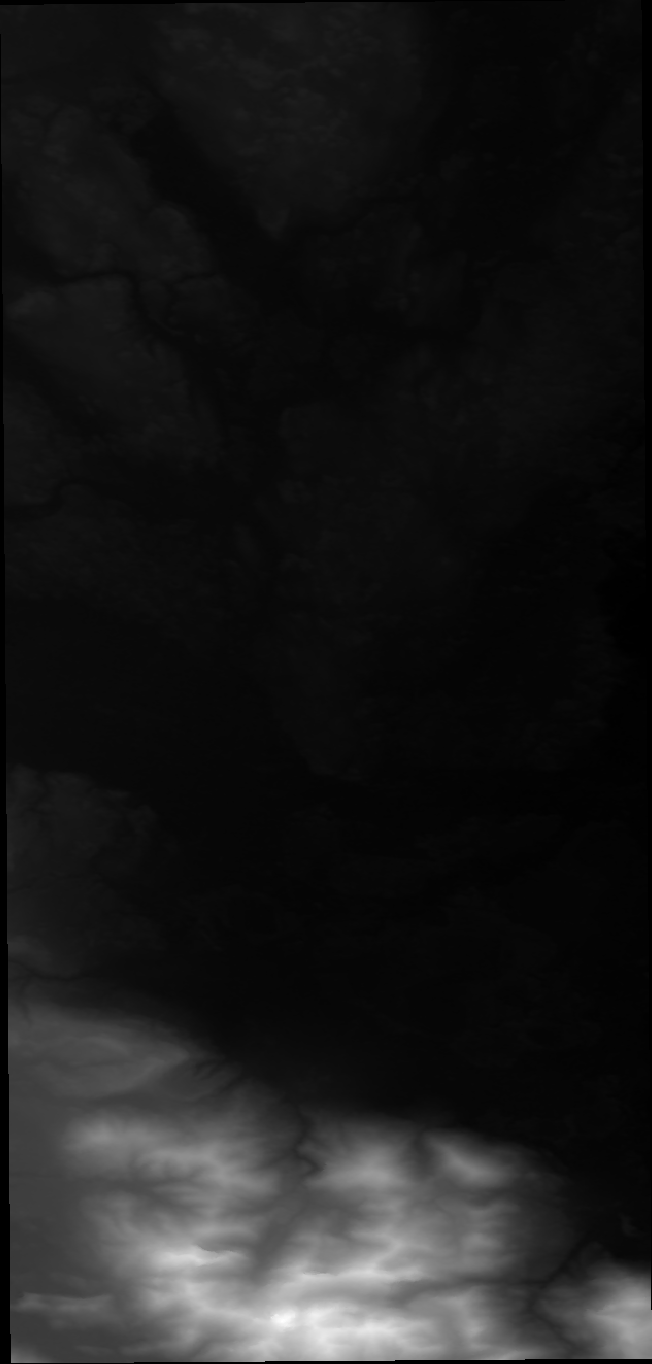

In [8]:
dem_dataset, raw_dem_data, dem_geo_t, dem_proj, dem_metadata = open_dataset("./srtm_data/srtm.tif")
missing_data_value = raw_dem_data.min()
min_dem_value = raw_dem_data[raw_dem_data > missing_data_value].min()
visible_dem = raw_dem_data.copy()
visible_dem[visible_dem <= missing_data_value] = min_dem_value
visible_dem = rescale_elevation_data(visible_dem)
Image.fromarray(visible_dem.astype(np.uint8))

In [9]:
 dem_proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [10]:
import rasterio

In [11]:
OrbView_file = "./orbview3_data/3v050905m0000880351a520001100172m_001659557.tif"

OrbView_scene = rasterio.open(OrbView_file)

In [12]:
OrbView_scene.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2004, 'height': 7168, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'pixel'}

In [13]:
# OrbView_scene is our open dataset object
print(OrbView_scene)

# dataset name
print(OrbView_scene.name)

# number of bands 
print("the number of bands:",OrbView_scene.count)

# Projection
print('CRS: ',OrbView_scene.crs)

# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
print('Transform: ',OrbView_scene.transform)

# Dimensions
print('Width: ',OrbView_scene.width)
print('Height: ',OrbView_scene.height)

# resolution 
print("image rsolution: ", OrbView_scene.res)

# Bounds 
print('Boundary: ',OrbView_scene.bounds)

# data format
print('Driver: ', OrbView_scene.driver)

# No data values for all channels
print('NoData: ', OrbView_scene.nodatavals)

# Metadata 
print('Metdata: ',OrbView_scene.meta)

<open DatasetReader name='./orbview3_data/3v050905m0000880351a520001100172m_001659557.tif' mode='r'>
./orbview3_data/3v050905m0000880351a520001100172m_001659557.tif
the number of bands: 4
CRS:  None
Transform:  | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Width:  2004
Height:  7168
image rsolution:  (1.0, -1.0)
Boundary:  BoundingBox(left=0.0, bottom=7168.0, right=2004.0, top=0.0)
Driver:  GTiff
NoData:  (None, None, None, None)
Metdata:  {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2004, 'height': 7168, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
from rasterio.plot import show

In [15]:
blue, green, red, nir = OrbView_scene.read()

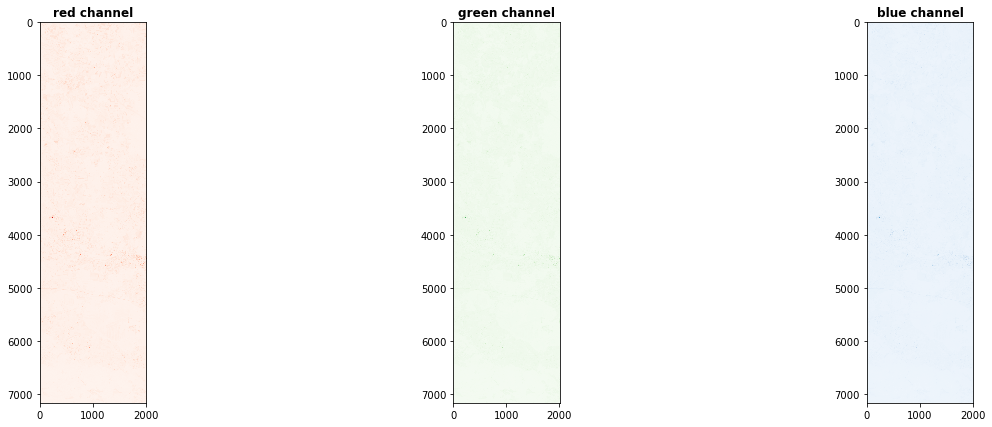

In [16]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((red), ax=axr, cmap='Reds',transform=OrbView_scene.transform, title='red channel')
show((green), ax=axg, cmap='Greens',transform=OrbView_scene.transform, title='green channel')
show((blue), ax=axb, cmap='Blues',transform=OrbView_scene.transform, title='blue channel')

In [17]:
rgb = np.dstack((red, green, blue))
nrg = np.dstack((nir, red, green))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


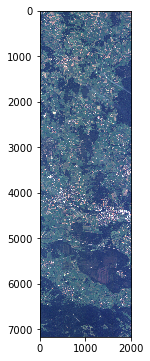

In [18]:
# plot the RGB stack to see a true-color representation
fig, ax = plt.subplots(figsize = (16,6))  
plt.imshow(rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


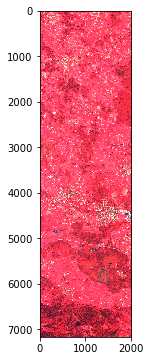

In [19]:
# False Color Composite
fig, ax = plt.subplots(figsize = (16,6))  
plt.imshow(nrg)

In [20]:
# Get some imagery
img_ds, img_data, img_geo_t, img_proj, img_meta = open_dataset('./orbview3_data/3v050905m0000880351a520001100172m_001659557.tif')
img_data_grey = img_data.mean(axis=0)

In [21]:
# rpcs = unpack_rpc_parameters(img_ds)
rpc_dict = img_ds.GetMetadata_Dict("RPC")

In [22]:
rpc_dict

{'HEIGHT_OFF': '+0576.000 meters',
 'HEIGHT_SCALE': '+0899.000 meters',
 'LAT_OFF': '+47.88530000 degrees',
 'LAT_SCALE': '+00.16240000 degrees',
 'LINE_DEN_COEFF': '+1.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 +0.000000000000000E+00 ',
 'LINE_NUM_COEFF': '+2.044756800000000E-03 +8.732351700000000E-03 -1.038867300000000E+00 +2.547346300000000E-02 +4.431273100000000E-04 -3.822551000000000E-06 -6.167488400000000E-04 -1.485462600000000E-04 -6.910879700000000E-03 +1.524124800000000E-05 +1.567070100000000E-06 +3.054565400000000E-07 -1.831818000000000E-05 -2.018899800000000E-08 -1.873739900000000E-07 +8.198

In [23]:
import geopandas as gpd

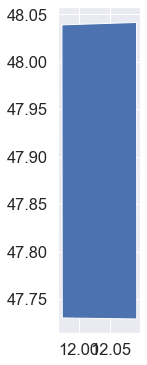

In [24]:
sns.set(font_scale=1.5)

footprint = gpd.read_file('./orbview3_data/3v050905m0000880351a520001100172m_001659557.shp')
footprint.plot(figsize=(15,6))

In [25]:
footprint

,Comp_Id,Project,Latitude,Longitude,Image_Date,CloudCover,Filename,Media_Id,Datum,Projection,geometry
0,3V050905M0000880351A520001100172M_001659557,USGS_MSI,48.042095,11.97293,2005-09-05T10:15:49.012800Z,999,3V050905M0000880351A520001100172M_001659557.tif,001659557_3of4,WGS_84,Geographic,"POLYGON ((11.97293 48.03954, 12.09023 48.04210..."


In [26]:
footprint[['geometry']]

,geometry
0,"POLYGON ((11.97293 48.03954, 12.09023 48.04210..."


In [27]:
footprint.bounds

,minx,miny,maxx,maxy
0,11.97293,47.729495,12.090522,48.042095


In [28]:
# Not sure which extend to set here!
# You've mentioned that some data comes with a polygon / bounding box that represents the footprint of the imegery
# By that do you mean this is supposed to be the footprint of the image after the orthorectification? 
# If yes then the footprint I used here is the right one?
rpc_dict["MAX_LAT"] = "48.0420950999999974"
rpc_dict["MAX_LONG"] = "12.0905222999999999"
rpc_dict["MIN_LAT"] = "47.7294953000000035" 
rpc_dict["MIN_LONG"] = "11.9729300999999992"

In [29]:
RPC_coeffs = unpack_rpc_parameters(rpc_dict)
# I got error here: 'dict' object has no attribute 'GetMetadata_Dict'

AttributeError: 'dict' object has no attribute 'GetMetadata_Dict'

In [ ]:
# Could you explain the bitness=12? does it matter and how?#< the origianl image is at UInt16 so I suppose it stays at that?
# rescaled_img = gaussian_rescale(img_data_grey, bitness=12).astype(np.uint8)

In [ ]:
img_data_warped, gsd, ul_lon, ul_lat = make_ortho(
    #48.0420950999999974,
    #12.0905222999999999,
    #47.7294953000000035,
    #11.9729300999999992,
    #15000, How to determine the width here?
    rescaled_img,
    RPC_coeffs,
    raw_dem_data,
    dem_geo_t,
    # -50 !?
)

In [30]:
# by the way: could you explain what to do here in case someone wants to use the SARDEM ? I foud the documentation here https://pypi.org/project/sardem/
!createdem -164 67 2 2  --data-source NASA --output elevation.dem
# this code does not work for me! I just wait for 30minn and nothing happened!

^C


In [31]:
#I hope by runnig this code properly I will be able to orthorectify the SkySat Basic Scene Product (L2B) that I have!